In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import math
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
flat = pd.read_csv('/datasets/real_estate_data.csv',  sep='\t')

In [3]:
flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Всего 23699 записей. Пропущенные значения обнаружены в следующих столбцах:
    1. ceiling_height (14504) 
    2. living_area (21796)
    3. is_apartment(2775)
    4. kitchen_area (21421)
    5. balcony (12180)
    6. locality_name (23650)
    7. airports_nearest (18157) 
    8. cityCenters_nearest (18180) 
    9. parks_around3000 (18181) 
    10. parks_nearest (8079)
    11. ponds_around3000 (18181) 
    12. ponds_nearest (9110)
    13. days_exposition (20518) 
Так же были обнаружены неподходящие типы данных, а именно:
    1. float64 для столбца floors_total. Считаю это ненужным, т.к. число этажей не может быть нецелочисленным
    2. object для столбца is_apartment. т.к. в нем есть пропуски, просто привести его к bool не получится, надо заполнять пропуски
    3. float64 для столбца balcony. Опять та же ситуация, что и с количеством этажей в доме. Количество балконов не может быть нецелочисленным
    4. float64 для столбца parks_around3000. Количество парков не может быть нецелочисленным

### Шаг 2. Предобработка данных

In [4]:
#Заполнение пропусков в названии населенного пункта словом unknown
flat['locality_name'].fillna('unknown', inplace=True)

In [5]:
#Рассчет средней высоты потолков в разрезе населенных пунктов 
name_to_height = flat.groupby('locality_name')['ceiling_height'].median().to_dict()

In [6]:
flat['ceiling_height'].fillna(-1, inplace=True)

In [7]:
def fill_ceiling_height(row):
    if row['ceiling_height'] == -1:
        return name_to_height[row['locality_name']]
    return row['ceiling_height']

In [8]:
#Заполнение пропущенных значений высоты потолков медианной высотой потолков 
flat['ceiling_height'] = flat.apply(fill_ceiling_height, axis=1)

In [9]:
#Заполним количество балконов нулями(если не указали количество - значит их нет:)
flat['balcony'].fillna(0, inplace=True)

Далее я рассчитываю коэффициент соотношения общей и жилой площади в разрезе количества комнат для заполнения пропусков в жилой площади

In [10]:
living_area_coef = flat.query('living_area>0').pivot_table(index='rooms', values=['total_area', 'living_area'], aggfunc='mean')

living_area_coef['coef'] = living_area_coef['living_area'] / living_area_coef['total_area']
living_area_coef

,living_area,total_area,coef
rooms,,,
0,18.865246,27.642678,0.682468
1,17.893552,37.477817,0.477444
2,31.736849,55.754385,0.569226
3,47.387941,77.421487,0.612077
4,66.983223,106.674141,0.627924
5,100.009247,160.047979,0.624870
6,130.983636,200.162121,0.654388
7,163.564151,256.441509,0.637822
8,168.683333,259.233333,0.650701


In [11]:
flat['living_area'].fillna(-1, inplace=True)

In [12]:
def living_area_calc(row, living_area_calc):
    if row['living_area'] == -1:
        room = row['rooms']
        #total_area = data['total_area']
        coef = living_area_calc.query('rooms == @room')['coef'].iloc[0]
        return coef*row['total_area']
    return row['living_area']   

In [13]:
flat['living_area'] = flat.apply(living_area_calc, axis=1, args=(living_area_coef,))

Для заполнения пропусков в кухонной площади использовал другой метод. Я нашел соотношение жилой площади к площади кухни для каждой записи, где данные не пропущены. После чего нашел самый часто встречаемый коэффициент и рассчитал площадь кухни с помощью этого коэффициента

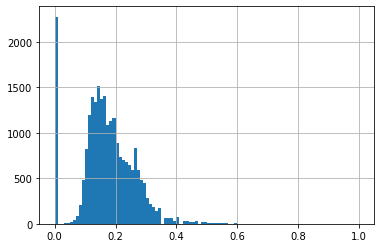

In [14]:
flat['part_kitchen_area'] = round(flat['kitchen_area'] / flat['total_area'], 2)
flat['part_kitchen_area'].fillna(0, inplace=True)
flat['part_kitchen_area'].hist(bins=100, range=(0, 1))

In [15]:
flat['kitchen_area'].fillna(flat['total_area'] * 0.14, inplace=True)

После чего решил выполнить проверку корректности моих гипотез, и понял что такая гипотеза не универсальна

In [16]:
(flat['total_area'] - flat['living_area'] - flat['kitchen_area']).sort_values()

7239     -29.800000
7857     -22.200000
4366     -20.300000
6802     -20.000000
12481    -19.769474
            ...    
19961    227.000000
12859    289.400000
15651    290.000000
14991    325.400000
19540    378.300000
Length: 23699, dtype: float64

Оцениваю количество записей, для которых гипотеза не сработала

In [17]:
flat.query('total_area < living_area+kitchen_area').count()

total_images            98
last_price              98
total_area              98
first_day_exposition    98
rooms                   98
ceiling_height          98
floors_total            98
living_area             98
floor                   98
is_apartment            23
studio                  98
open_plan               98
kitchen_area            98
balcony                 98
locality_name           98
airports_nearest        68
cityCenters_nearest     68
parks_around3000        68
parks_nearest           30
ponds_around3000        68
ponds_nearest           35
days_exposition         88
part_kitchen_area       98
dtype: int64

Так как данных немного, было решено откинуть их

In [18]:
flat = flat.query('total_area > living_area+kitchen_area')

По аналогии с количеством балконов было заполнено поле is_apartment значением False

In [19]:
flat['is_apartment'].fillna(False, inplace=True)

так как в признаке "количество этажей" небольшое количество пропусков, решено откинуть и эти данные

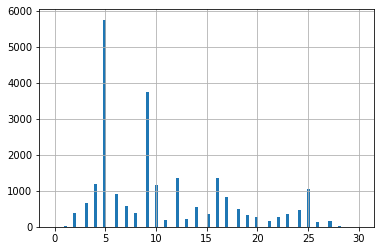

In [20]:
flat['floors_total'].hist(bins=100, range=(0, 30))

In [21]:
flat.dropna(subset = ['floors_total'], inplace = True)

Далее я заполняю количество парков и озер в пределах 3 км нулями, так как если человек, составлявший объявление, пропустил это поле, значит, что парков/озер рядом нет. Так же заполняю пропущенные значения в поле ближайший парк/озеро -1

In [22]:
flat['parks_around3000'].fillna(0, inplace=True)
flat['ponds_around3000'].fillna(0, inplace=True)
flat['parks_nearest'].fillna(-1, inplace=True)
flat['ponds_nearest'].fillna(-1, inplace=True)

Так как нас в дальнейшем будут интересовать только проданные квартиры, откидываем непроданные квартиры

In [23]:
flat.dropna(subset=['days_exposition'], inplace=True)

Приведем тип поля к нужным, на мой взгляд, и так же предобработаем признак "Название нас. пункта"(приведем к нижнему регистру)

In [24]:
flat['floors_total'] = flat['floors_total'].astype('int')
flat['balcony'] = flat['balcony'].astype('int')
flat['parks_around3000'] = flat['parks_around3000'].astype('int')
flat['ponds_around3000'] = flat['ponds_around3000'].astype('int')
flat['locality_name'] = flat['locality_name'].str.lower()
flat['days_exposition'] = flat['days_exposition'].astype('int')

In [25]:
flat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20292 entries, 1 to 23697
Data columns (total 23 columns):
total_images            20292 non-null int64
last_price              20292 non-null float64
total_area              20292 non-null float64
first_day_exposition    20292 non-null object
rooms                   20292 non-null int64
ceiling_height          20199 non-null float64
floors_total            20292 non-null int64
living_area             20292 non-null float64
floor                   20292 non-null int64
is_apartment            20292 non-null bool
studio                  20292 non-null bool
open_plan               20292 non-null bool
kitchen_area            20292 non-null float64
balcony                 20292 non-null int64
locality_name           20292 non-null object
airports_nearest        15680 non-null float64
cityCenters_nearest     15702 non-null float64
parks_around3000        20292 non-null int64
parks_nearest           20292 non-null float64
ponds_around3000     

Оставшиеся пропущенные значения по высоте потолков забьем медианой по всем высотам потолка. Причиной оставшихся пропущенных значений является случаи, когда есть нас.пункт, в котором продается одна или несколько квартир, для которых не указана высота потолка

In [26]:
flat['ceiling_height'].fillna(flat.query('ceiling_height != "NaN"')['ceiling_height'].median(), inplace=True)

Заполним пропуски по расстоянию до аэропорта/центра нас.пункта значением -1

In [27]:
flat['cityCenters_nearest'].fillna(-1, inplace=True)
flat['airports_nearest'].fillna(-1, inplace=True)

#### Выводы по пункту 2
Были заполнены пропущенные значения там, где это возможно/есть определенная логика заполнения
В некоторых признаках данные с пропущенными значениями были отброшены во избежание аномалии в данных

### Шаг 3. Посчитайте и добавьте в таблицу

In [28]:
flat['square_meter_price'] = flat['last_price'] / flat['total_area']

In [29]:
flat['first_day_exposition'] = pd.to_datetime(flat['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
flat['week_day'] = flat['first_day_exposition'].dt.weekday
flat['month'] = flat['first_day_exposition'].dt.month
flat['year'] = flat['first_day_exposition'].dt.year

In [30]:
def floor(data):
    if data['floor'] == 1:
        return 'первый'
    elif data['floor'] == data['floors_total']:
        return 'последний'
    else:
        return 'другой'
        
flat['floors_category'] = flat.apply(floor, axis=1)

In [31]:
flat['floor_space_ratio'] = flat['living_area'] / flat['total_area']
flat['kitchen_to_total_ratio'] = flat['kitchen_area'] / flat['total_area']

#### Выводы по пункту 3
В данном пункте добавлены новые столбцы, расчет которых достаточно тривиален. на значения некоторых расчетных величин я ссылался ранее.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

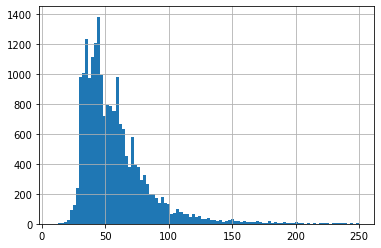

In [32]:
flat['total_area'].hist(bins=100, range=(10, 250))#30-50

По данной гистограме видно, что основное количество представленных квартир имеет площадь от 30 до 50 кв.м.

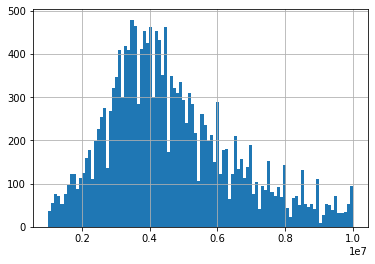

In [33]:
flat['last_price'].hist(bins=100, range=(1000000, 10000000))#2.5-4.3kk

Данная гистгорамма показывает, что разброс цен для большинства представленных квартир находится в промежутке от 2.5 до 4.3 млн 

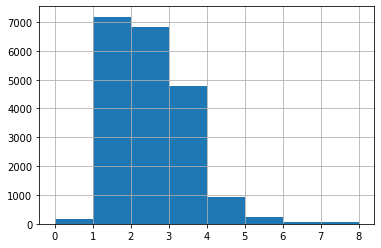

In [34]:
flat['rooms'].hist(bins=8, range=(0, 8))#1-2-3

Данная гистгорамма показывает, что основная часть квартир имеет от 1 до 3 комнат

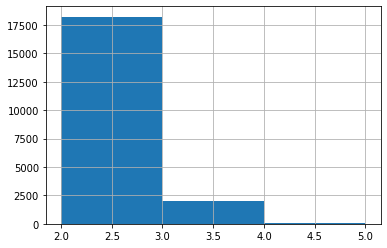

In [35]:
flat['ceiling_height'].hist(bins=3, range=(2, 5))#2-3

Данная гистгорамма показывает, что большинство высот потолков находится в промежутке 2-3 м.

Далее я произвожу расчет средней длительности продажи квартиры

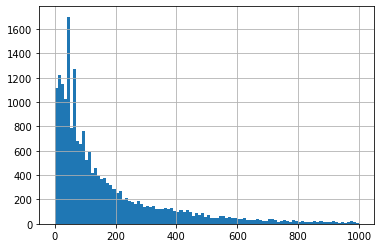

In [36]:
flat['days_exposition'].hist(bins=100,range=(0,1000))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3d1148e610>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3d11494c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3d1148e590>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3d1149c6d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3d1149cbd0>],
 'means': []}

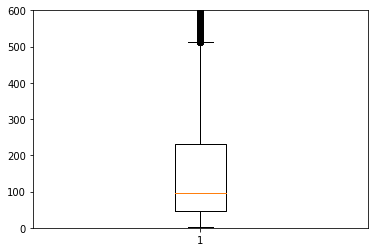

In [37]:
plt.ylim(0,600)
plt.boxplot(flat['days_exposition'])

Как видно из диаграммы размаха средняя длительность продажи квартиры около 90 дней 

Далее я нахожу значения-выбросы и откидываю их

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3d113fd290>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3d113fdd50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3d113f65d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3d114067d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3d11406cd0>],
 'means': []}

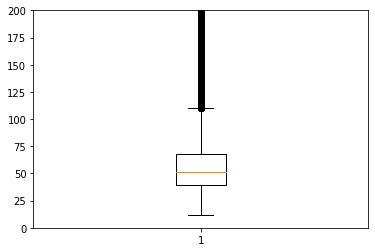

In [38]:
#flat['total_area'].hist()
plt.ylim(0,200)
plt.boxplot(flat['total_area'])

Для общей площади большинство данных лежит в промежутке от 20 до 115 кв.м. Для этого я создаю новый датафрейм, в который буду записывать значения без выбросов

In [39]:
flat_filtered = flat.query('total_area>20 and total_area<115')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3d113668d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3d113dac50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3d113dac10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3d1136cd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3d11366ed0>],
 'means': []}

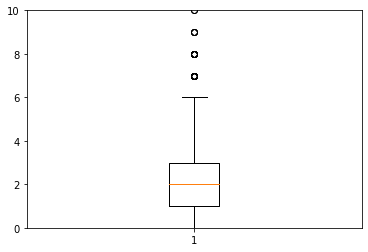

In [40]:
#flat_filtered['rooms'].hist(bins = 11,range=(0,11))
plt.ylim(0,10)
plt.boxplot(flat['rooms'])

In [41]:
flat_filtered = flat_filtered.query('rooms<6')

Относительно количества комнат можно сделать следующий вывод: квартиры с 7 и более комнатами являются выбросами. Найдем такое значение для высоты потолков 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3d0f30e850>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3d0f300bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3d0f300b90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3d0f312d10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3d0f30ee50>],
 'means': []}

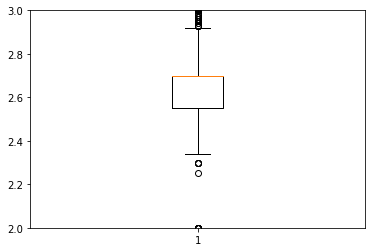

In [42]:
#flat_filtered['ceiling_height'].hist(range=(2,5))
plt.ylim(2,3)
plt.boxplot(flat['ceiling_height'])

In [43]:
flat_filtered = flat.query('ceiling_height>2.3 and ceiling_height<2.95')

И последний признак, где могут быть выбросы - это цена

In [44]:
flat_filtered['last_price'].max()

763000000.0

In [45]:
flat_filtered['last_price'].min()

12190.0

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3d0f27dc10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3d0f2826d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3d0f271f50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3d0f27dd10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3d0f28c650>],
 'means': []}

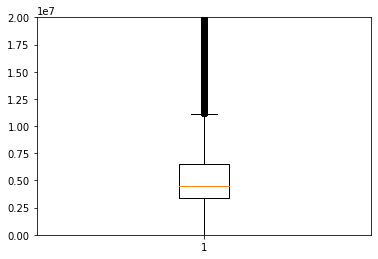

In [46]:
#flat_filtered['last_price'].hist(bins=1000, range=(1000000, 40000000))
plt.ylim(0,20000000)
plt.boxplot(flat['last_price'])

In [47]:
flat_filtered = flat_filtered.query('last_price > 700000 and last_price < 10000000')

In [48]:
flat_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16889 entries, 1 to 23695
Data columns (total 30 columns):
total_images              16889 non-null int64
last_price                16889 non-null float64
total_area                16889 non-null float64
first_day_exposition      16889 non-null datetime64[ns]
rooms                     16889 non-null int64
ceiling_height            16889 non-null float64
floors_total              16889 non-null int64
living_area               16889 non-null float64
floor                     16889 non-null int64
is_apartment              16889 non-null bool
studio                    16889 non-null bool
open_plan                 16889 non-null bool
kitchen_area              16889 non-null float64
balcony                   16889 non-null int64
locality_name             16889 non-null object
airports_nearest          16889 non-null float64
cityCenters_nearest       16889 non-null float64
parks_around3000          16889 non-null int64
parks_nearest           

                     total_area     rooms  last_price  cityCenters_nearest
total_area             1.000000  0.807169    0.659950             0.006585
rooms                  0.807169  1.000000    0.420736             0.008966
last_price             0.659950  0.420736    1.000000             0.158652
cityCenters_nearest    0.006585  0.008966    0.158652             1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d0f23f310>,
      dtype=object)

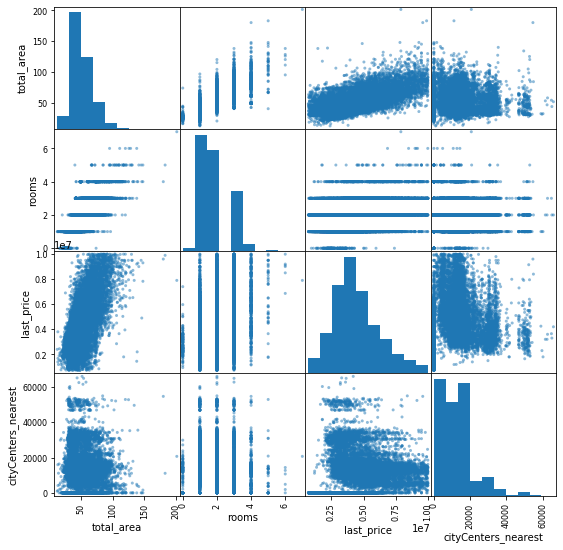

In [49]:
flat_stat_multi = flat_filtered.loc[:, ['total_area', 'rooms', 'last_price', 'cityCenters_nearest']]
print(flat_stat_multi.corr())
pd.plotting.scatter_matrix(flat_stat_multi, figsize=(9, 9))

Также я рассмотрел зависимость цены от некоторых параметров, а именно: общая площадь, количество комнат, расстояние до центра нас.пункта. были выявлены следующие зависимости:
    - чем больше комнат, тем больше цена
    - чем больше площадь, тем больше цена
    - расстояние до центра города почти не влияет на ценообразование

                 last_price
floors_category            
другой            4350000.0
первый            3650000.0
последний         3847500.0


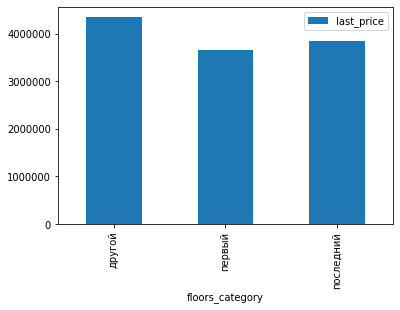

In [50]:
flat_floors_category = flat_filtered.pivot_table(index='floors_category', values='last_price', aggfunc='median')
flat_floors_category.plot(y='last_price', kind ='bar')
print(flat_floors_category)

Изучив распределение цен по признаку первый-другой-последний этаж я пришел к выводу что рейтинг цены квартиры зависит от этажа, а именно: самые дешевые - первый этаж, самые дорогие находятся ни на первом, ни на последнем этаже

          last_price
week_day            
4          4150000.0
6          4150000.0
0          4200000.0
1          4200000.0
2          4200000.0
3          4200000.0
5          4200000.0


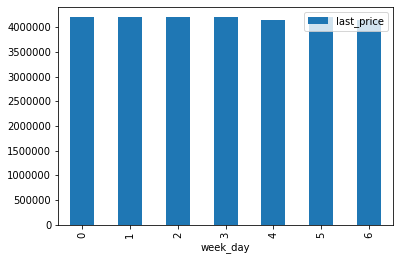

In [51]:
flat_group_by_week_name = flat_filtered.pivot_table(index='week_day', values='last_price', aggfunc='median')
flat_group_by_week_name.plot(y='last_price', kind ='bar')
print(flat_group_by_week_name.sort_values(by='last_price'))

Аналогично с днем недели можно сделать следующие выводы:
    -самые дорогие квартиры выставляют на продажу во вторник
    -самые дешевые выставляют на продажу в субботу и воскресенье

       last_price
month            
6       4050000.0
3       4150000.0
7       4150000.0
2       4190000.0
12      4194500.0
8       4199000.0
1       4200000.0
4       4200000.0
5       4200000.0
9       4200000.0
10      4200000.0
11      4250000.0


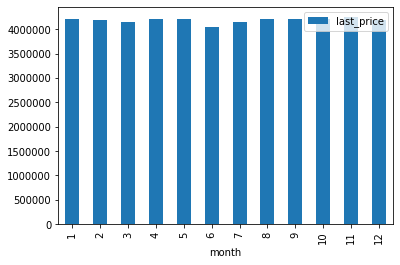

In [52]:
flat_group_by_month = flat_filtered.pivot_table(index='month', values='last_price', aggfunc='median')
flat_group_by_month.plot(y='last_price', kind ='bar')
print(flat_group_by_month.sort_values(by='last_price'))

Аналогично с месяцем можно сделать следующие выводы:
    -самые дорогие квартиры выставляют на продажу в сентябре
    -самые дешевые выставляют на продажу в июне

In [ ]:
flat_group_by_year = flat_filtered.pivot_table(index='year', values='last_price', aggfunc='median')
flat_group_by_year.plot(y='last_price', kind ='bar')
print(flat_group_by_year.sort_values(by='last_price'))

в разрезе по годам видна тенденция на резкое удешевление квартир, после чего квартиры снова постепенно начинают дорожать. Самые дорогие квартиры были выставлены на продажу в 14 году, самые дешевые - в 17

In [ ]:
flat_filtered_tmp = flat_filtered[flat_filtered['cityCenters_nearest'] != -1]
flat_locality_name = (flat_filtered_tmp
                             .pivot_table(index='locality_name', values ='square_meter_price', aggfunc='count')
                             .sort_values(by = 'square_meter_price', ascending = False)
                             .head(11))
flat_locality_name

в данном списке представлены населенные пункты с самым большим количеством квартир. для решения поставленной задачи откинем СПБ тк по нему буде проведен отдельный анализ

In [ ]:
list_of_locality = ['посёлок шушары',
                    'колпино',
                    'посёлок парголово',
                    'пушкин',
                    'петергоф',
                    'сестрорецк',
                    'красное село',
                    'ломоносов',
                    'кронштадт',
                    'посёлок металлострой']
flat_locality = flat_filtered_tmp.query('locality_name in @list_of_locality')
data_pivot_locality_name = (flat_locality
                                .pivot_table(index='locality_name', 
                                                   values =['square_meter_price', 'cityCenters_nearest'], 
                                                   aggfunc='median')
                                .sort_values(by = 'square_meter_price', ascending = False))
data_pivot_locality_name

В данной таблице представлены данные по средней цене за квадратный метр. самые дешевые квартиры по цене за квадратный метр находятся в Ломоносове, самые дорогие - в Сестрорецке

Необходимо добавить признак с количеством километров до центра

In [ ]:
flat_filtered['cityCenter_km'] = round(flat_filtered['cityCenters_nearest'] / 1000)

Для наглядности я построил гистограмму в которой показано распределение цены квартир в СПБ. Необходимо по данной гистограмме найти центральную зону

In [ ]:
tmp = (flat_filtered
    .query('locality_name=="санкт-петербург"')
    .pivot_table(index='cityCenter_km', values='last_price', aggfunc='median'))
tmp.hist(bins=100, range=(4000000, 5500000), figsize=(12,6))

In [ ]:
tmp.sort_values(by='last_price')

Оснвываясь на гистограмме и усредненным значениям цены центральная зона получилась в промежутке от 10 до 15 км

In [ ]:
flat_central_segment = flat_filtered.query('cityCenter_km > 10 and cityCenter_km < 15')

Далее я произвожу анализ центральной зоны

In [ ]:
flat_stat_central = flat_central_segment.loc[:, ['total_area', 'last_price', 'rooms', 'ceiling_height', 'floor']]
print(flat_stat_central.corr())
pd.plotting.scatter_matrix(flat_stat_central, figsize=(12, 12))

Был произведен анализ ценообразования квартир в центральном сегменте СПБ. Были выявленны следующие зависимости:
    - общая площадь, количество комнат, высота потолков и этаж влияют на ценообразование
    - сильнее всего на ценообразование влияет общая площадь, меньше всего - этаж

### Шаг 5. Общий вывод

В данной работе идет поиск параметров, которые влияют на ценообразование. Данные, которые были предоставлены, были с проблемами, а именно:
    - Пропущенные значения
    - Несоответствие типов данных
Была выполнена предобработка данных для последующего анализа. были заполнены пропуски или удалены некоторые значения (см шаг 2).
Затем были рассчитаны дополнительные параметры для оценки.
После чего начался поиск параметров, которые влияют на ценообразование квартир. Такими параметрами являются:
    - Общая площадь недвижимости
    - Количество комнат
    - Этаж
    - Высота потолков
Неожиданностью для меня стало то, что расстояние до центра нас.пункта не особо влияет на ценообразование. 